# 4c. Evaluate predictions of emergency demand

The previous notebook demonstrated the full implementation in code of training models for use at UCLH using the functions provided in `patientflow`. 

The final step is to evaluate the predicted distributions against observed numbers. I will evaluate the predictions by specialty using the approaches covered in a [previous notebook](3b_Evaluate_group_snapshots.ipynb).

* histograms of observed versus expected values
* qq plots

As the predictions for yet-to-arrive patients are aspirational, these cannot be directed evaluated against observed numbers of admissions in the prediction window. In reality, due to poor ED performance, few may have been admitted within the window. Similarly for the group of patients in the ED, we calculate the predicted number of beds needed within the prediction window, but the observed numbers will not reflect the targets.

We can, however, evaluate the predictions in a slightly different way. 

* For the patients in ED, we can compare the predicted bed counts needed for each specialty against observed numbers admitted to each specialty from among patients comprising each group snapshot in the test set period. In effect, this means ignoring how long it took patients to be admitted. 
* For the yet-to-arrive patients, we can apply the aspirational ED targets to the observed arrival times of patients in the test set, rendering the predicted and observed distributions comparable.

## Set up the notebook environment

In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from patientflow.load import set_project_root
project_root = set_project_root()


Inferred project root: /Users/zellaking/Repos/patientflow


## Set file paths and load data

I'm going to use real patient data from UCLH to demonstrate the implementation. 

As noted previously, you can request the datasets that are used here on [Zenodo](https://zenodo.org/records/14866057). Alternatively you can use the synthetic data that has been created from the distributions of real patient data. If you don't have the public data, change the argument in the cell below from `data_folder_name='data-public'` to `data_folder_name='data-synthetic'`.

In [3]:
from patientflow.load import set_file_paths

# set file paths
data_folder_name = 'data-public'
data_file_path = project_root / data_folder_name

data_file_path, media_file_path, model_file_path, config_path = set_file_paths(
    project_root, 
    data_folder_name=data_folder_name,
    config_file = 'config.yaml')

Configuration will be loaded from: /Users/zellaking/Repos/patientflow/config.yaml
Data files will be loaded from: /Users/zellaking/Repos/patientflow/data-public
Trained models will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public
Images will be saved to: /Users/zellaking/Repos/patientflow/trained-models/public/media


In [4]:
import pandas as pd
from patientflow.load import load_data

# load ED snapshots data
ed_visits = load_data(data_file_path, 
                    file_name='ed_visits.csv', 
                    index_column = 'snapshot_id',
                    sort_columns = ["visit_number", "snapshot_date", "prediction_time"], 
                    eval_columns = ["prediction_time", "consultation_sequence", "final_sequence"])
ed_visits.snapshot_date = pd.to_datetime(ed_visits.snapshot_date).dt.date

# load data on inpatient arrivals
inpatient_arrivals = inpatient_arrivals = load_data(data_file_path, 
                    file_name='inpatient_arrivals.csv')
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(inpatient_arrivals['arrival_datetime'], utc = True)


## Set modelling parameters

The parameters are used in training or inference. They are set in config.json in the root of the repository and loaded by `load_config_file()`

In [5]:
# load params
from patientflow.load import load_config_file
params = load_config_file(config_path)

start_training_set, start_validation_set, start_test_set, end_test_set = params["start_training_set"], params["start_validation_set"], params["start_test_set"], params["end_test_set"]


## Apply temporal splits

In [6]:
from patientflow.prepare import create_temporal_splits

train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="snapshot_date",
)

train_inpatient_arrivals_df, _, test_inpatient_arrivals_df = create_temporal_splits(
    inpatient_arrivals,
    start_training_set,
    start_validation_set,
    start_test_set,
    end_test_set,
    col_name="arrival_datetime",
)

Split sizes: [53801, 6519, 19494]
Split sizes: [7730, 1244, 3701]


## Train models to predict bed count distributions for patients currently in the ED

This time I'll use a larger parameter grid, while still limiting the search space to a few hyperparameters for expediency.

In [7]:

from patientflow.train.classifiers import train_classifier
from patientflow.load import get_model_key

grid = { # Current parameters
    'n_estimators': [30, 40, 50],  # Number of trees
    'subsample': [0.7, 0.8, 0.9],  # Sample ratio of training instances
    'colsample_bytree': [0.7, 0.8, 0.9],  # Sample ratio of columns for each tree
   } 

exclude_from_training_data = [ 'snapshot_date', 'prediction_time','visit_number', 'consultation_sequence', 'specialty', 'final_sequence', ]

ordinal_mappings = {
    "latest_acvpu": ["A", "C", "V", "P", "U"],
    "latest_obs_manchester_triage_acuity": [
        "Blue",
        "Green",
        "Yellow",
        "Orange",
        "Red",
    ],
    "latest_obs_objective_pain_score": [
        "Nil",
        "Mild",
        "Moderate",
        "Severe\\E\\Very Severe",
    ],
    "latest_obs_level_of_consciousness": ["A", "C", "V", "P", "U"],
}

# create a dictionary to store the trained models
admissions_models = {}
model_name = 'admissions'

# Loop through each prediction time
for prediction_time in ed_visits.prediction_time.unique():
    print(f"Training model for {prediction_time}")
    model = train_classifier(
        train_visits=train_visits_df,
        valid_visits=valid_visits_df,
        test_visits=test_visits_df,
        grid=grid,
        exclude_from_training_data=exclude_from_training_data,
        ordinal_mappings=ordinal_mappings,
        prediction_time=prediction_time,
        visit_col="visit_number",
        calibrate_probabilities=True,
        calibration_method="isotonic",
        use_balanced_training=True,
    )
    model_key = get_model_key(model_name, prediction_time)
    
    admissions_models[model_key] = model

Training model for (12, 0)
Training model for (15, 30)
Training model for (6, 0)
Training model for (9, 30)
Training model for (22, 0)


## Train specialty model

Here, when training the model predicting specialty of admission, the `apply_special_category_filtering` parameter has been set to True, so it will be assumed that all patients under 18 on arrival will be admitted to a paediatric specialty. 

In [8]:
from patientflow.predictors.sequence_predictor import SequencePredictor

spec_model = SequencePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=True,
)

spec_model = spec_model.fit(train_visits_df)

## Train models for yet-to-arrive patients



In [9]:
from patientflow.predictors.weighted_poisson_predictor import WeightedPoissonPredictor
from patientflow.prepare import create_yta_filters

x1, y1, x2, y2 = params["x1"], params["y1"], params["x2"], params["y2"]
prediction_window = params["prediction_window"]
yta_time_interval = params["yta_time_interval"]

specialty_filters = create_yta_filters(ed_visits)
yta_model_by_spec =  WeightedPoissonPredictor(filters = specialty_filters, verbose=False)

# calculate the number of days between the start of the training and validation sets; used for working out daily arrival rates
num_days = (start_validation_set - start_training_set).days

if 'arrival_datetime' in train_inpatient_arrivals_df.columns:
    train_inpatient_arrivals_df.set_index('arrival_datetime', inplace=True)

yta_model_by_spec =yta_model_by_spec.fit(train_inpatient_arrivals_df, 
              prediction_window=prediction_window, 
              yta_time_interval=yta_time_interval, 
              prediction_times=ed_visits.prediction_time.unique(), 
              num_days=num_days )

## Generate predicted distributions for each specialty and prediction time for patients in ED

As we are treating paediatric patients differently from adults, the code below includes logic to identify eligible snapshots when caclculating for paediatric versus adult subgroups. When evaluating the predictions for adult destinations (medical, surgical and haem/onc), patients under 18 will be excluded. When evaluating the predictions for paediatric patients, adults will be excluded.

In [10]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist
from patientflow.predict.emergency_demand import get_specialty_probs

prob_dist_dict_all = {}
specialties = ['medical', 'surgical', 'haem/onc', 'paediatric']

special_params = spec_model.special_params

special_category_func = special_params["special_category_func"]
special_category_dict = special_params["special_category_dict"]
special_func_map = special_params["special_func_map"]

# Get predictions of admission to specialty
test_visits_df.loc[:, "specialty_prob"] = get_specialty_probs(
    specialties,
    spec_model,
    test_visits_df,
    special_category_func=special_category_func,
    special_category_dict=special_category_dict,
)

# initialise a dictionary to store the probability distributions for each specialty and prediction time
prob_dist_dict_all = {}

# Process each time of day
for _prediction_time in ed_visits.prediction_time.unique():

    prob_dist_dict_for_pats_in_ED = {}

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key(model_name, _prediction_time)
    
    for specialty in specialties:
        print(f"Predicting bed counts for {specialty} specialty, for all snapshots in the test set")
        prob_dist_dict_for_specialty = {}

        # Get indices of patients who are eligible for this specialty
        func = special_func_map.get(specialty, special_func_map["default"])
        non_zero_indices = test_visits_df[
            test_visits_df.apply(func, axis=1)
        ].index

        test_df_eligible = test_visits_df.copy()
        test_df_eligible = test_df_eligible.loc[non_zero_indices]

        # get the probability of admission to the specialty for eligible patients
        # for patients under 18, the probability of admission to paediatric is 1
        prob_admission_to_specialty = test_df_eligible["specialty_prob"].apply(
            lambda x: x[specialty]
        )

        # Prepare patient snapshots for the eligible patients
        X_test, y_test = prepare_patient_snapshots(
            df=test_df_eligible, 
            prediction_time=_prediction_time, 
            single_snapshot_per_visit=False,
            exclude_columns=exclude_from_training_data, 
            visit_col='visit_number'
        )

        # filter the probability of admission to the specialty for the eligible patients
        filtered_prob_admission_to_specialty = prob_admission_to_specialty.loc[
            non_zero_indices
        ]

        group_snapshots_dict = prepare_group_snapshot_dict(
            test_df_eligible[test_df_eligible.prediction_time == _prediction_time]
        )

        admitted_to_specialty = test_df_eligible['specialty'] == specialty

        # get probability distribution for this time of day, for this specialty, for patients in ED
        prob_dist_dict_for_pats_in_ED[specialty] = get_prob_dist(
            group_snapshots_dict, X_test, y_test, admissions_models[model_key], 
            weights=filtered_prob_admission_to_specialty,
            category_filter=admitted_to_specialty, 
            normal_approx_threshold=30
            ) 
        

    prob_dist_dict_all[f'{model_key}'] = prob_dist_dict_for_pats_in_ED



Processing :(12, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 

## Visualise the performance of emergency demand prediction models for patients in the ED

Below I show various ways to evaluate the predicted distributions:

* histograms of observed versus expected values
* QQ plots
* CORU plots

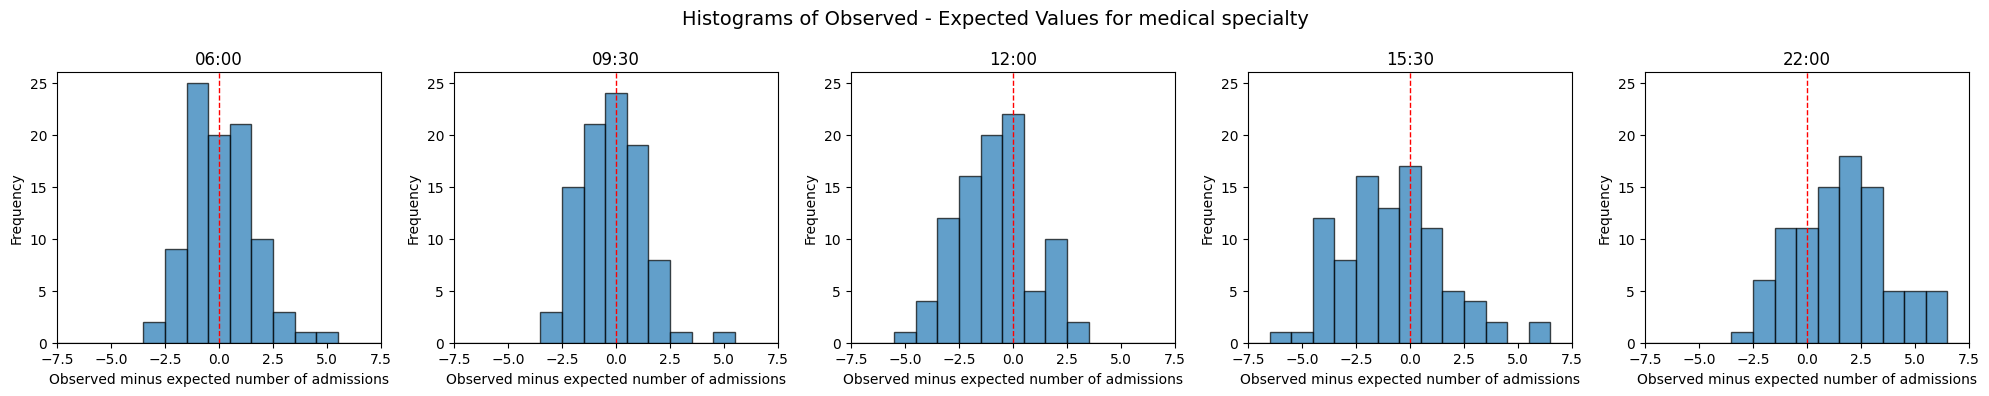

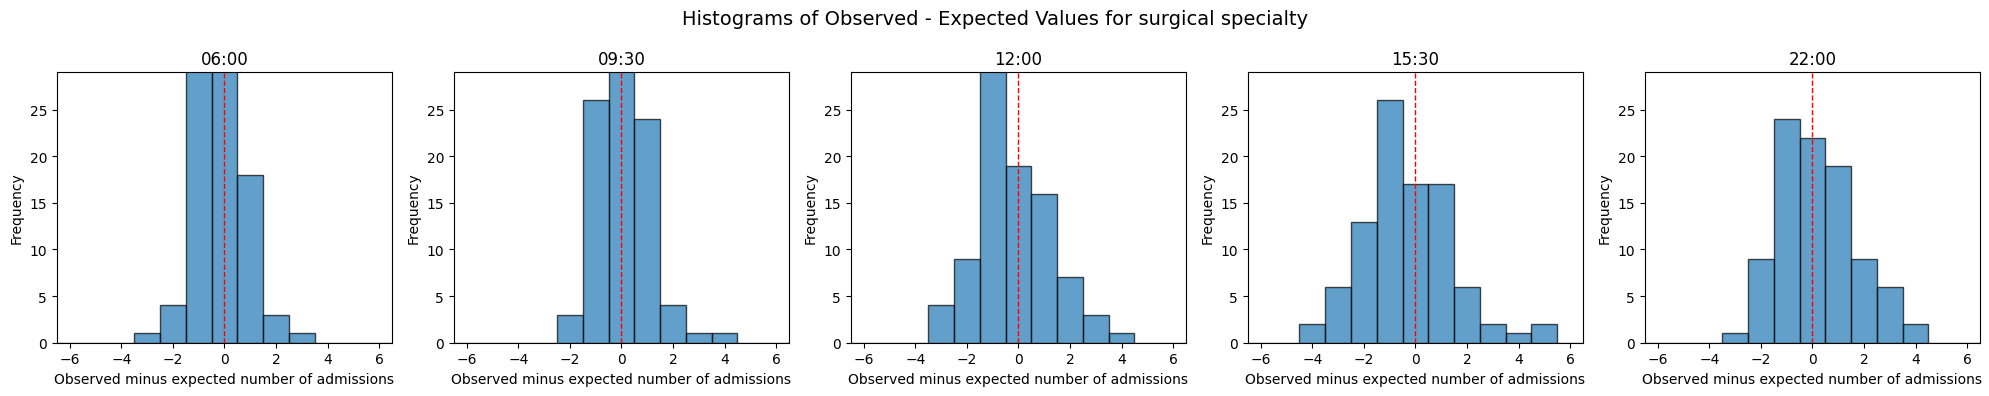

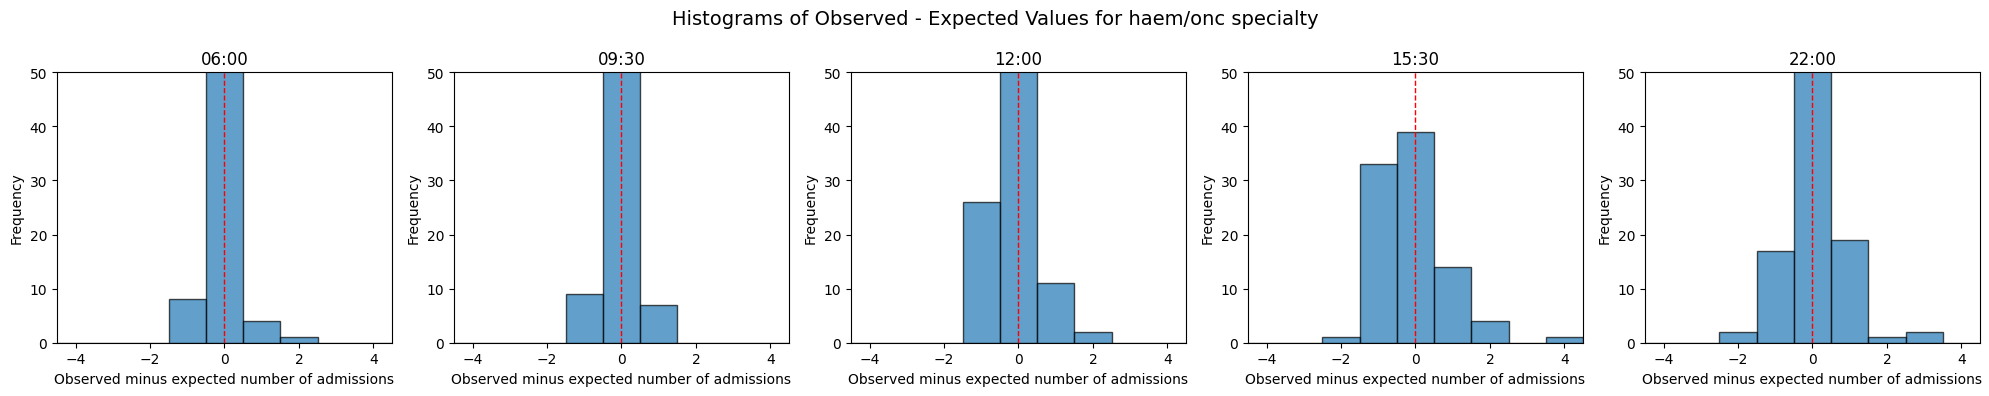

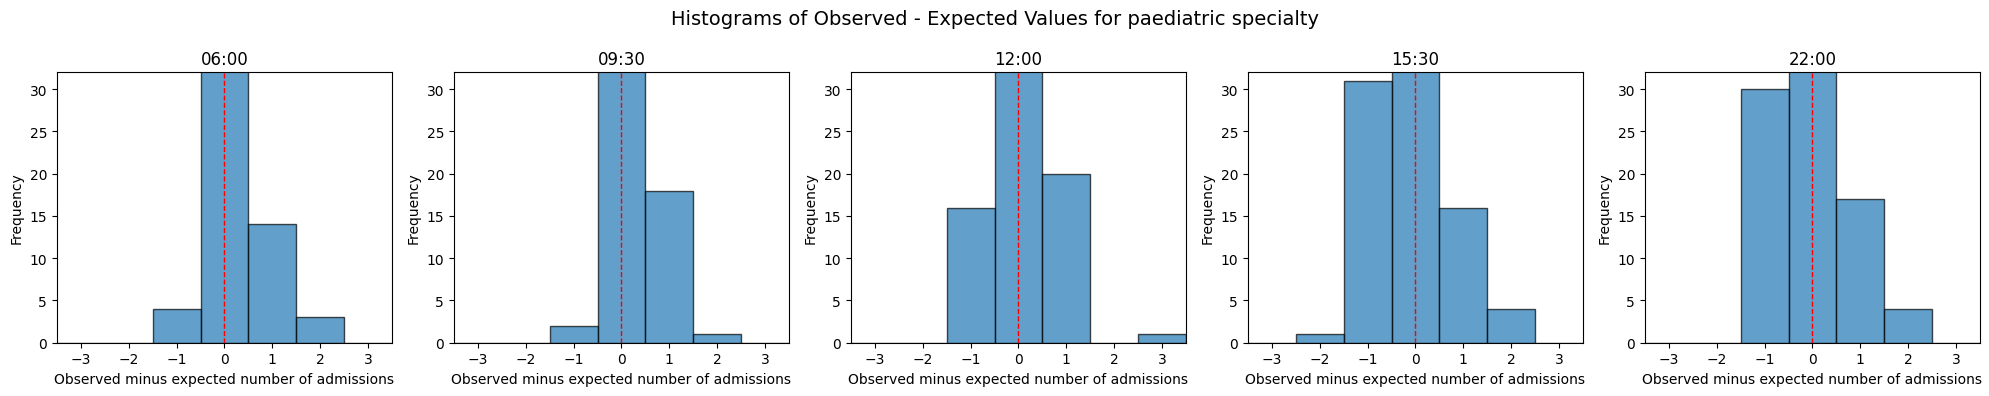

In [11]:
from patientflow.evaluate import calc_mae_mpe
from patientflow.viz.evaluation_plots import plot_observed_against_expected

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}
    results = calc_mae_mpe(specialty_prob_dist)
    plot_observed_against_expected(results, 
                                   main_title=f"Histograms of Observed - Expected Values for {specialty} specialty",)


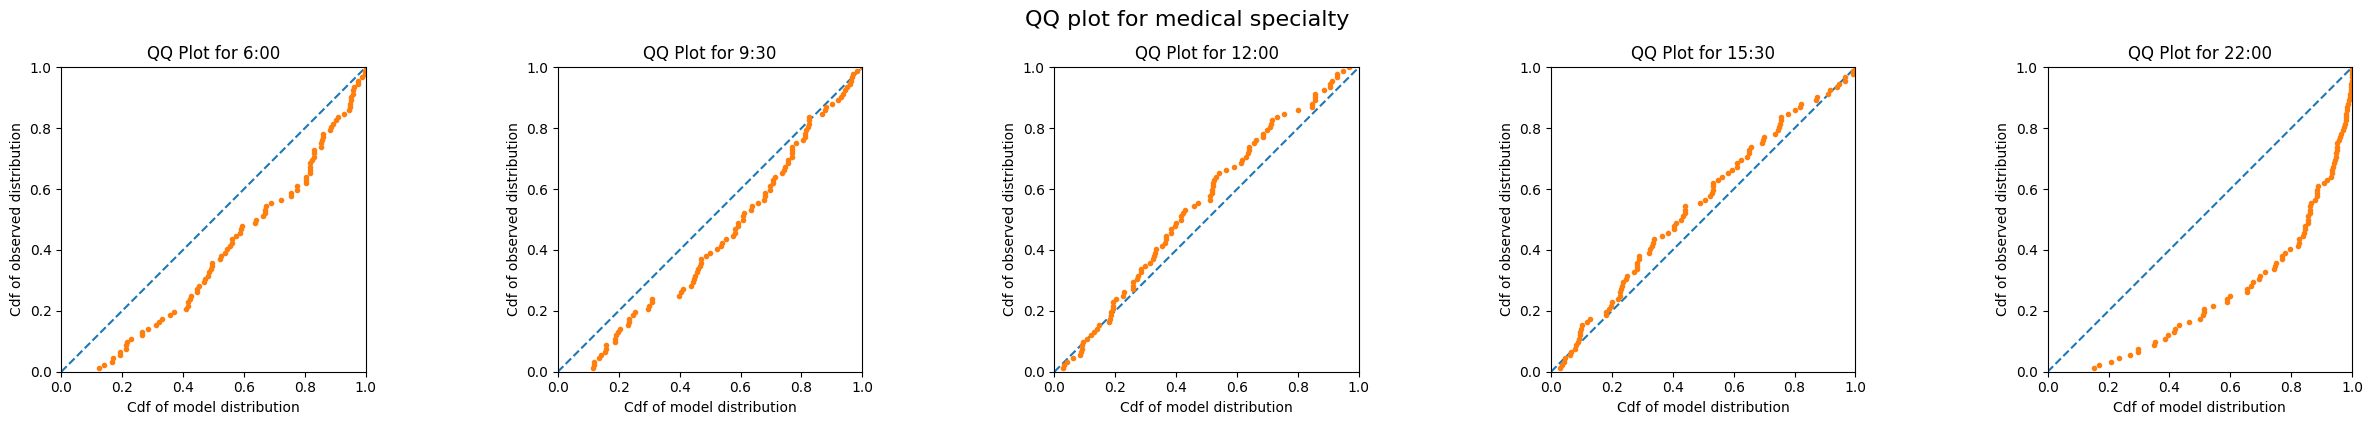

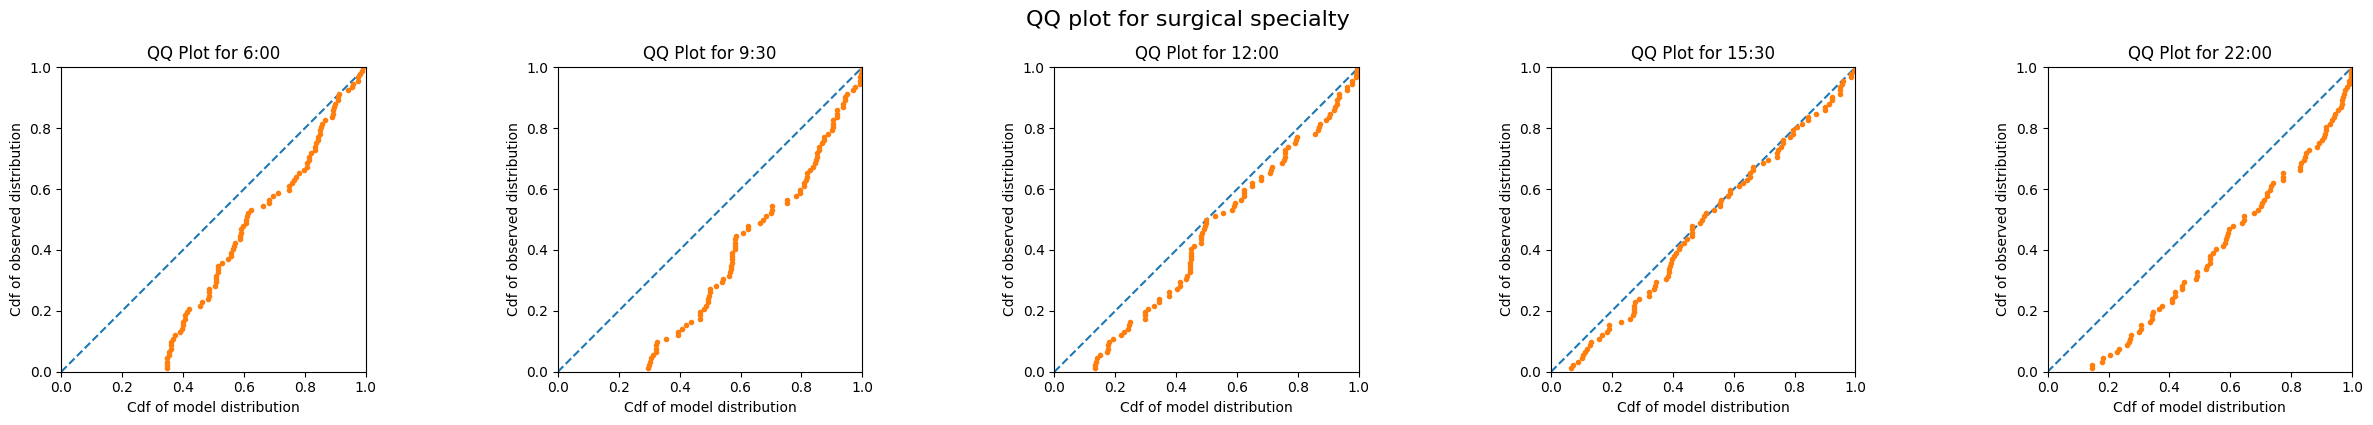

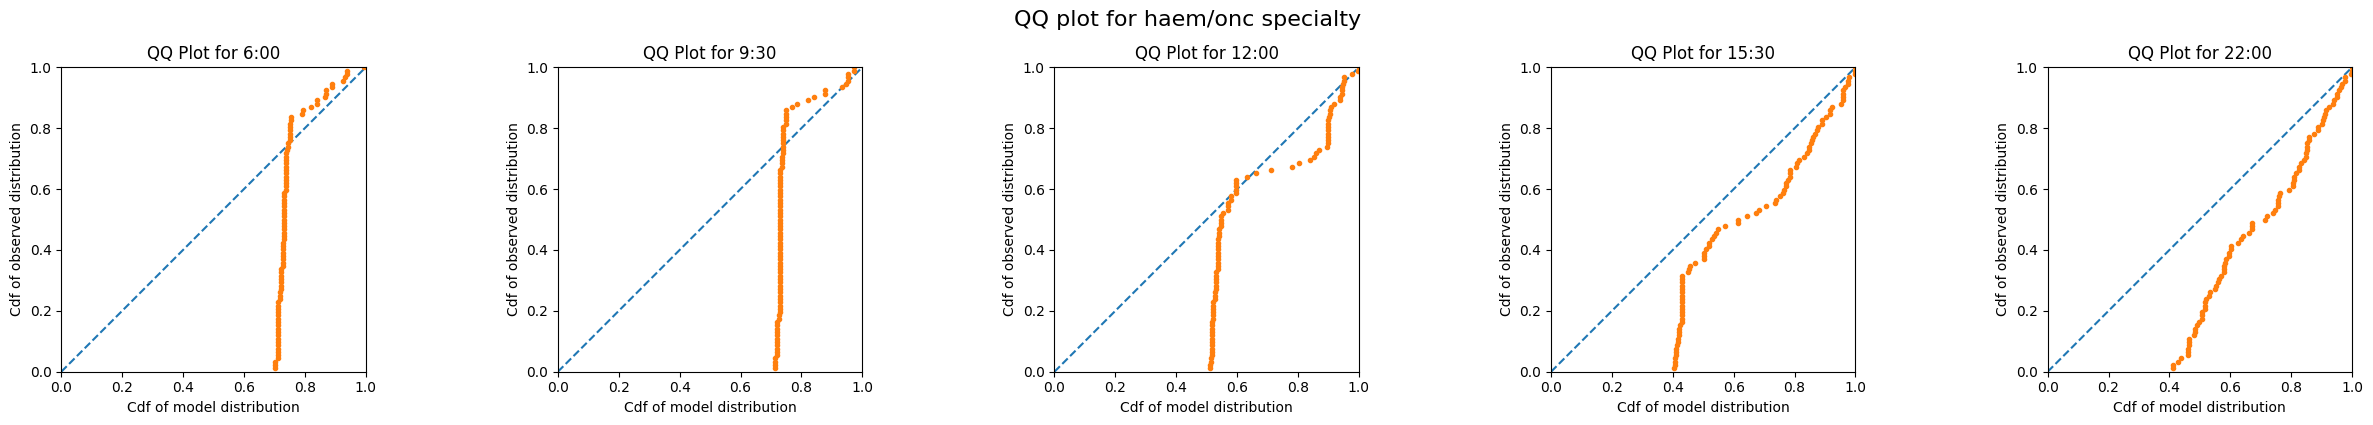

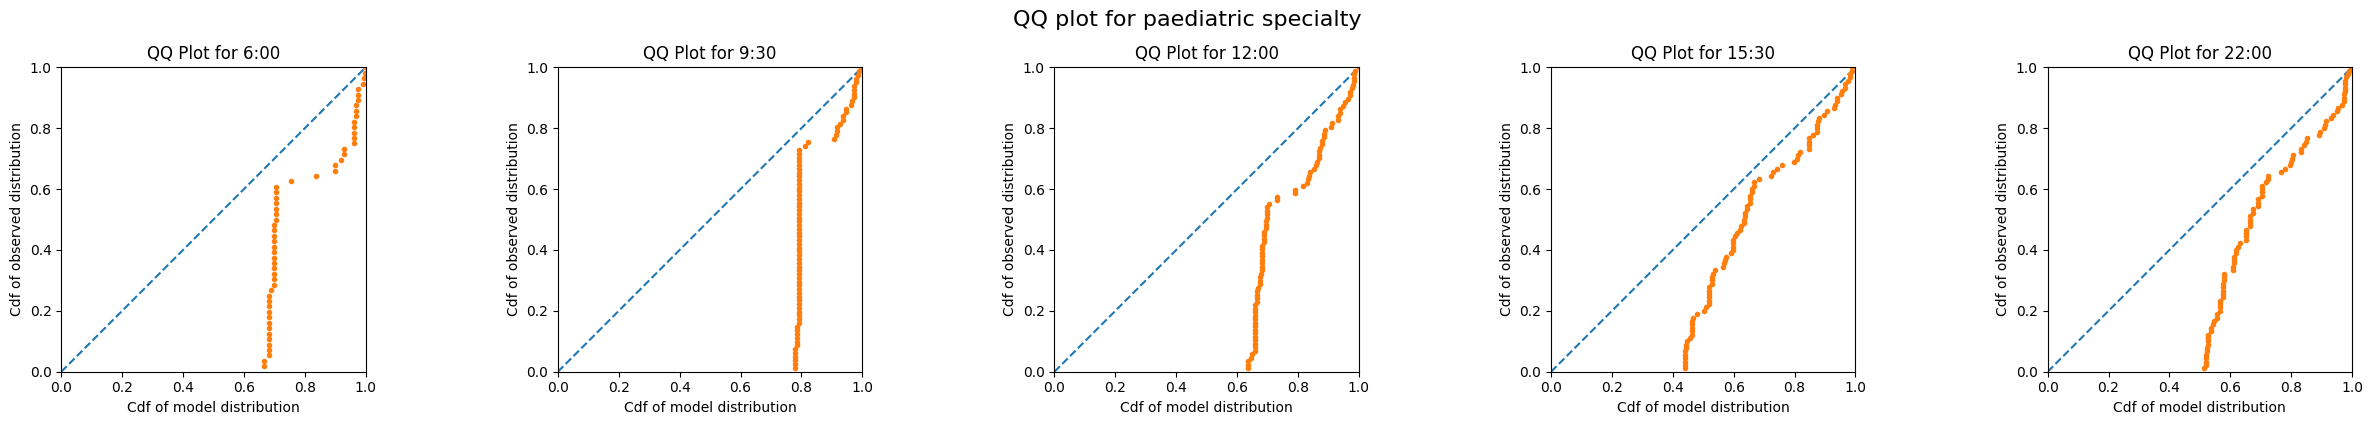

In [12]:
from patientflow.viz.qq_plot import qq_plot

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    qq_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"QQ plot for {specialty} specialty")

The models perform best for medical and surgical specialties, which have more snapshots. These specialties show better calibration, particularly at 12:00 and 15:30. The 22:00 models show weak performance, which will partly be a result of the admissions model itself being worse for that time of day. (See [this notebook](2c_Evaluate_patient_snapshot_models.ipynb) for evaluation of the admissions model performance.)

The haematology/oncology and paediatric models have show a stepwise pattern of sharp vertical jumps. Because these specialties admit few patients, they cause modelling challenges:

* Each admission or discharge has a larger proportional impact
* Random variations have stronger effects on daily census
* The models struggle to capture the true variability in these specialties


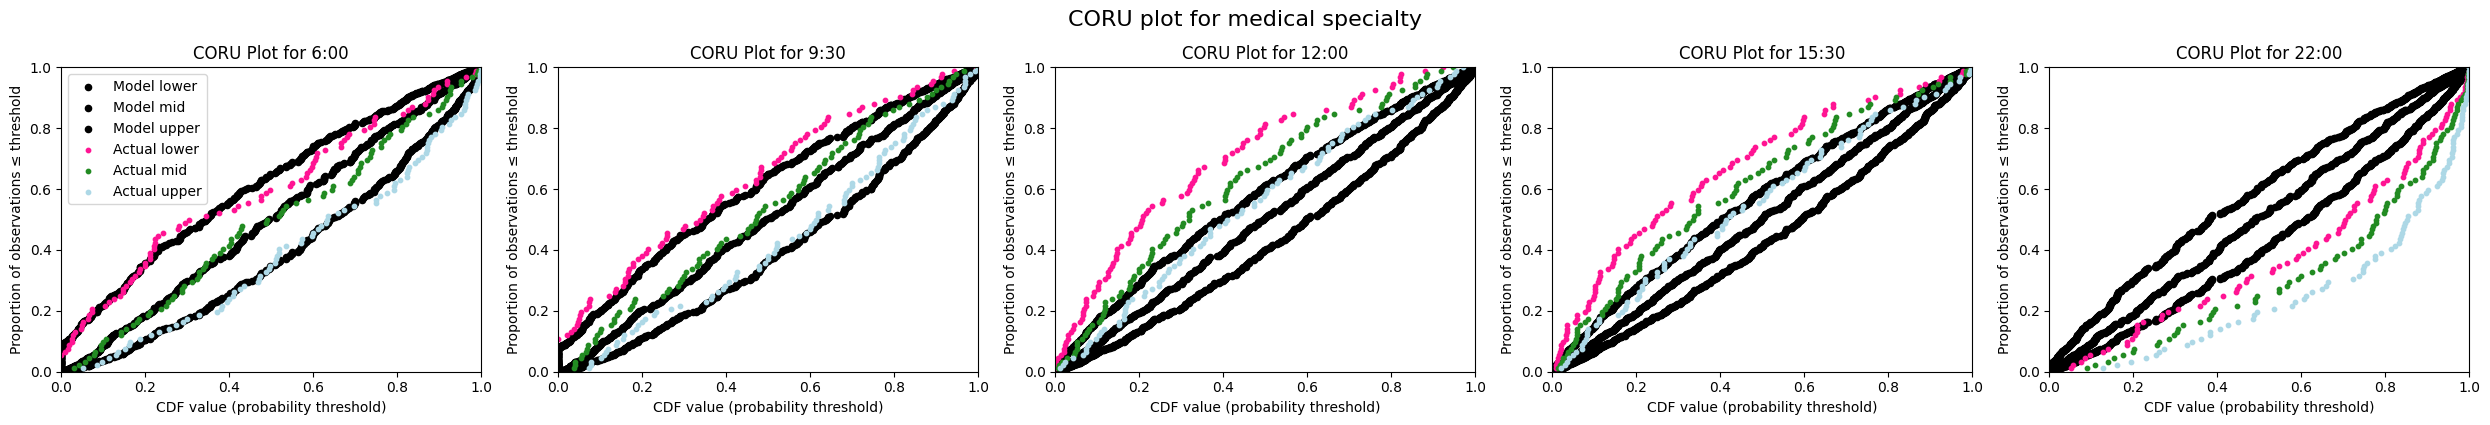

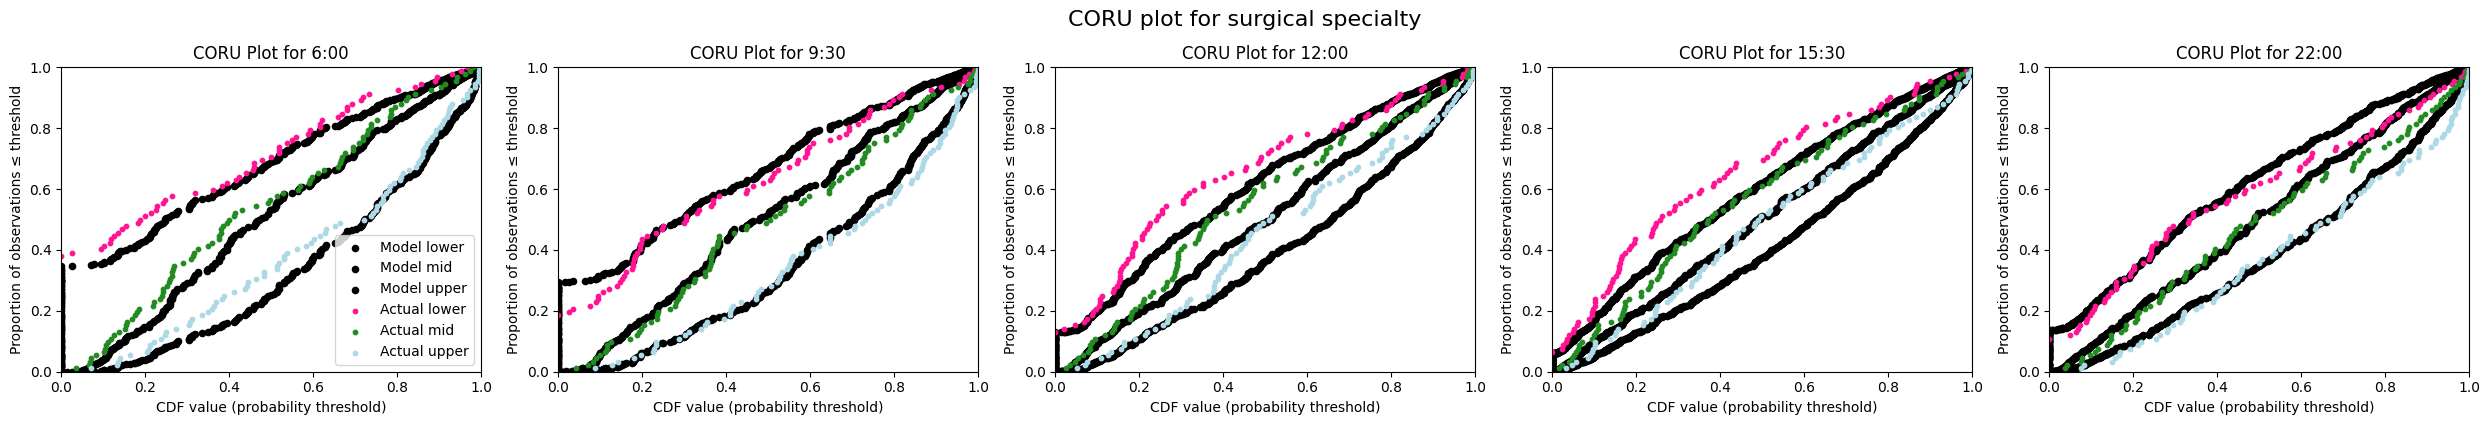

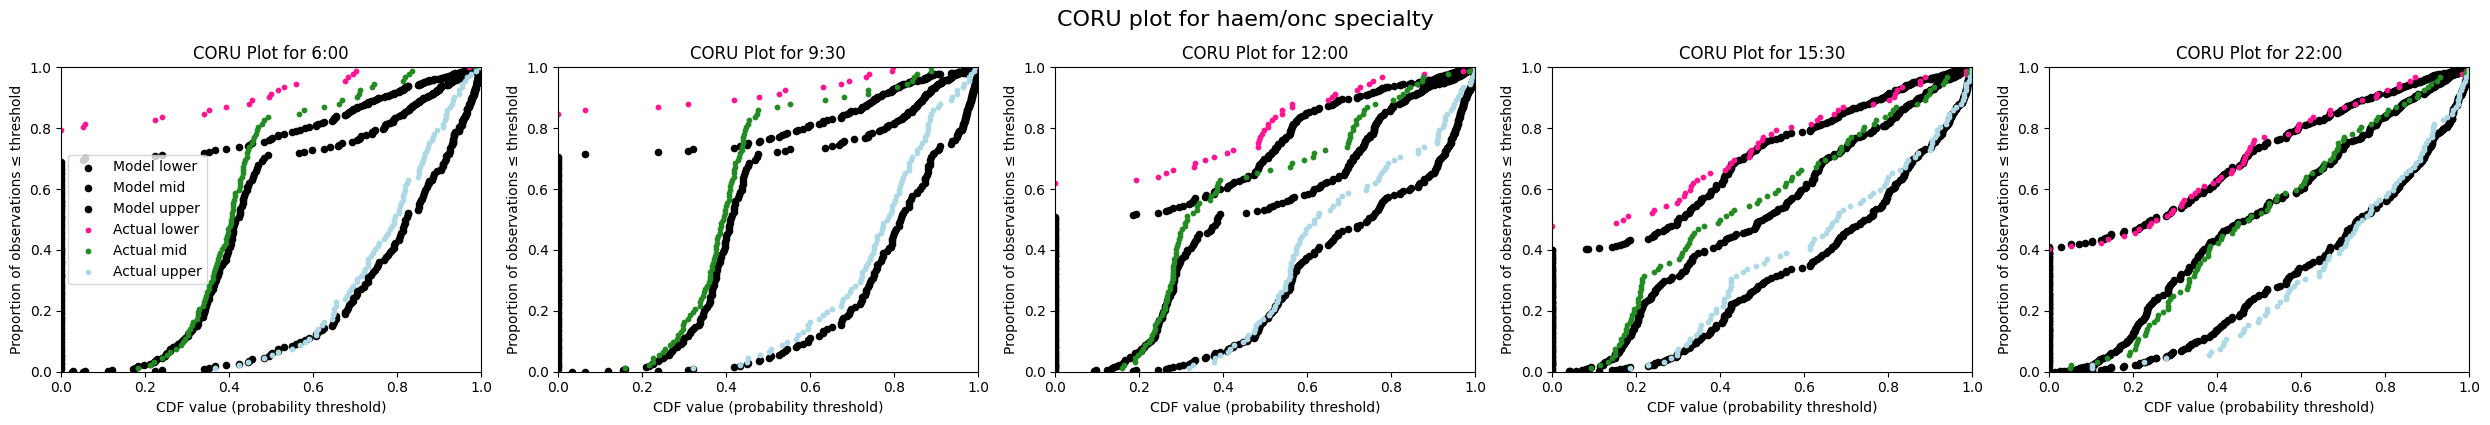

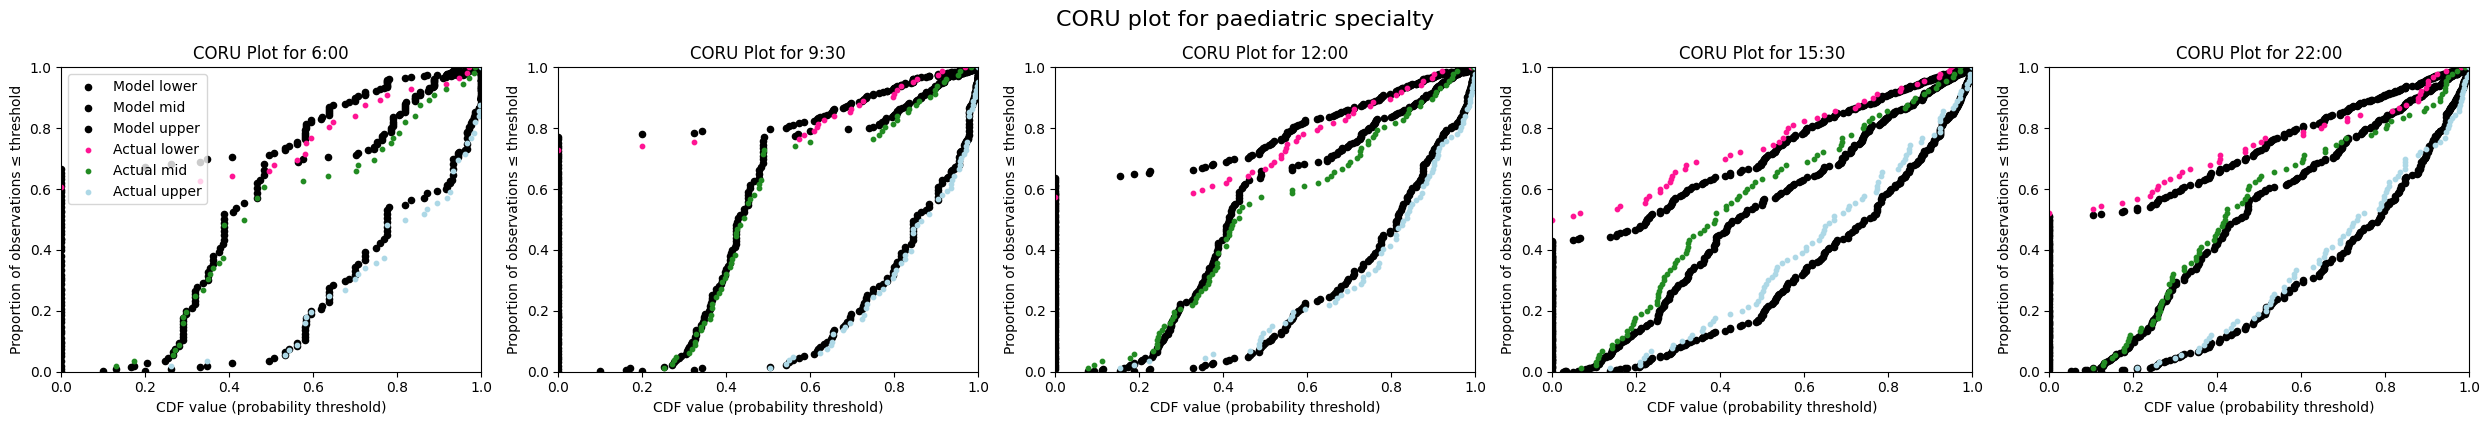

In [106]:
from patientflow.viz.coru_plot import coru_plot

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    coru_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"CORU plot for {specialty} specialty")

In [90]:
prob_dist_dict[dt]["agg_predicted"]['agg_proba']

0     4.931836e-04
1     1.838634e-03
2     6.697835e-03
3     1.972587e-02
4     4.697167e-02
5     9.044068e-02
6     1.408130e-01
7     1.772917e-01
8     1.805133e-01
9     1.486298e-01
10    9.896268e-02
11    5.328331e-02
12    2.319761e-02
13    8.165806e-03
14    2.323934e-03
15    5.346593e-04
16    9.942920e-05
17    1.494463e-05
18    1.815260e-06
19    1.781641e-07
20    1.412775e-08
21    9.049834e-10
22    4.682377e-11
23    1.956546e-12
24    6.594725e-14
25    1.887379e-15
26    0.000000e+00
27    0.000000e+00
28    0.000000e+00
29    0.000000e+00
30    0.000000e+00
31    0.000000e+00
32    0.000000e+00
33    0.000000e+00
34    0.000000e+00
35    0.000000e+00
36    0.000000e+00
37    0.000000e+00
38    0.000000e+00
39    0.000000e+00
40    0.000000e+00
41    0.000000e+00
42    0.000000e+00
43    0.000000e+00
44    0.000000e+00
45    0.000000e+00
46    0.000000e+00
Name: agg_proba, dtype: float64

In [89]:
agg_predicted = prob_dist_dict[dt]["agg_predicted"]

In [97]:
import numpy as np
prob_dist_dict = prob_dist_dict_all['admissions_2200']['medical']
all_distributions = []
for dt in prob_dist_dict:
    agg_predicted = prob_dist_dict[dt]["agg_predicted"]['agg_proba']
    
    # Calculate CDF values
    upper_cdf = agg_predicted.cumsum()
    lower_cdf = np.hstack((0, upper_cdf[:-1]))
    mid_cdf = (upper_cdf + lower_cdf) / 2
    
    # Store all predicted distributions for each time point
    for j, prob in enumerate(agg_predicted):
        all_distributions.append({
            'date': dt,
            'num_adm_pred': j,
            'probs': prob,
            'sample_time': dt,  # Using the same name as in R code
            'upper_M_discrete_value': upper_cdf[j],
            'lower_M_discrete_value': lower_cdf[j],
            'mid_M_discrete_value': mid_cdf[j]
        })

# Create DataFrame with all distributions
distr_coll = pd.DataFrame(all_distributions)
distr_coll[distr_coll.sample_time == distr_coll.sample_time.max()]

,date,num_adm_pred,probs,sample_time,upper_M_discrete_value,lower_M_discrete_value,mid_M_discrete_value
4182,2031-12-31,0,0.00128240837738306,2031-12-31,0.00128240837738306,0,0.000641204188691529
4183,2031-12-31,1,0.0110117091249035,2031-12-31,0.0122941175022866,0.00128240837738306,0.00678826293983482
4184,2031-12-31,2,0.0434397104296888,2031-12-31,0.0557338279319754,0.0122941175022866,0.0340139727171310
4185,2031-12-31,3,0.104755463393502,2031-12-31,0.160489291325478,0.0557338279319754,0.108111559628726
4186,2031-12-31,4,0.173346887917649,2031-12-31,0.333836179243127,0.160489291325478,0.247162735284302
4187,2031-12-31,5,0.209426596149072,2031-12-31,0.543262775392199,0.333836179243127,0.438549477317663
4188,2031-12-31,6,0.191844390165724,2031-12-31,0.735107165557922,0.543262775392199,0.639184970475060
4189,2031-12-31,7,0.136566148002361,2031-12-31,0.871673313560283,0.735107165557922,0.803390239559103
4190,2031-12-31,8,0.0767893672344804,2031-12-31,0.948462680794764,0.871673313560283,0.910067997177524
4191,2031-12-31,9,0.0344689835087079,2031-12-31,0.982931664303472,0.948462680794764,0.965697172549118


In [105]:
lower_M = distr_coll[['lower_M_discrete_value', 'probs']].copy()
lower_M.rename(columns={'lower_M_discrete_value': 'value'}, inplace=True)
lower_M = lower_M.sort_values('value')
lower_M['cum_weight'] = lower_M['probs'].cumsum()
lower_M['cum_weight_normed'] = lower_M['probs'].cumsum() / num_time_points
lower_M['dist'] = 'model lower'
lower_M

,value,probs,cum_weight,cum_weight_normed,dist
0,0.0,0.000493,0.000493,0.000005,model lower
3650,0.0,0.066979,0.067472,0.000733,model lower
3608,0.0,0.00461,0.072082,0.000783,model lower
676,0,0.0187498998786180,0.0908317571027166,0.000987301707638224,model lower
700,0.0,0.049,0.139831325210645,0.00151990570881136,model lower
...,...,...,...,...,...
2040,1.00000000000000,1.21189644025743e-22,92.0000000000000,1.00000000000000,model lower
2041,1.00000000000000,6.79386900435203e-25,92.0000000000000,1.00000000000000,model lower
381,1.00000000000000,3.63278439571990e-19,92.0000000000000,1.00000000000000,model lower
2044,1.00000000000000,6.81912006090176e-33,92.0000000000000,1.00000000000000,model lower


In [84]:
all_observations = []
time_pts = []
for dt in prob_dist_dict:
    agg_observed = prob_dist_dict[dt]["agg_observed"]
    time_pts.append(dt)
    
    # Store observation data
    all_observations.append({
        'date': dt,
        'num_adm': agg_observed,
        'sample_time': dt
    })

# Create DataFrame with all observations
adm_coll = pd.DataFrame(all_observations)
adm_coll

,date,num_adm,sample_time
0,2031-10-01,7,2031-10-01
1,2031-10-02,7,2031-10-02
2,2031-10-03,12,2031-10-03
3,2031-10-04,7,2031-10-04
4,2031-10-05,9,2031-10-05
...,...,...,...
87,2031-12-27,7,2031-12-27
88,2031-12-28,3,2031-12-28
89,2031-12-29,6,2031-12-29
90,2031-12-30,8,2031-12-30


In [78]:
merged_df = pd.merge(
    adm_coll,
    distr_coll.rename(columns={
        'num_adm_pred': 'num_adm',
        'lower_M_discrete_value': 'lower_E',
        'mid_M_discrete_value': 'mid_E',
        'upper_M_discrete_value': 'upper_E'
    }),
    on=['sample_time', 'num_adm'],
    how='inner'
)

# Add mid_E column
merged_df[merged_df.sample_time == merged_df.sample_time.max()]


,date_x,num_adm,sample_time,date_y,prob,upper_E,lower_E,mid_E
91,2031-12-31,3,2031-12-31,2031-12-31,[0.104755463393502],0.160489291325478,0.0557338279319754,0.108111559628726


In [103]:
for pred_type in ['lower']:
    # Get the column name from distr_coll
    col_name = f"{pred_type}_M_discrete_value"
    
    # Extract values
    values = distr_coll[col_name].values
    probs = distr_coll['probs'].values
    
    num_time_points = merged_df.sample_time.nunique()
    # Calculate distribution similar to R approach
    sorted_values = np.sort(values)
    n = len(sorted_values)
    print(n)
    
    # Calculate empirical CDF
    # unique_values, counts = np.unique(sorted_values, return_counts=True)
    # print(len(unique_values))
    cum_weights = np.cumsum(probs)
    cum_weights_normed = np.cumsum(probs) / num_time_points

lower_cdf =pd.DataFrame({
    'value': probs,
    'cum_weight_normed': cum_weights_normed
})

lower_cdf


4206


,value,cum_weight_normed
0,0.000493,0.000005
1,0.001839,0.000025
2,0.006698,0.000098
3,0.019726,0.000313
4,0.046972,0.000823
...,...,...
4201,2.90379457721854e-11,0.999999999999990
4202,6.19183635847857e-13,0.999999999999997
4203,7.03125730481698e-15,0.999999999999997
4204,3.07390881044777e-17,0.999999999999997


In [104]:
lower_M

,value,probs,cum_weight,cum_weight_normed,dist
0,0.0,0.000493,0.000493,0.000005,model lower
3650,0.0,0.066979,0.067472,0.000733,model lower
3608,0.0,0.00461,0.072082,0.000783,model lower
676,0,0.0187498998786180,0.0908317571027166,0.000987301707638224,model lower
700,0.0,0.049,0.139831325210645,0.00151990570881136,model lower
...,...,...,...,...,...
2040,1.00000000000000,1.21189644025743e-22,92.0000000000000,1.00000000000000,model lower
2041,1.00000000000000,6.79386900435203e-25,92.0000000000000,1.00000000000000,model lower
381,1.00000000000000,3.63278439571990e-19,92.0000000000000,1.00000000000000,model lower
2044,1.00000000000000,6.81912006090176e-33,92.0000000000000,1.00000000000000,model lower


In [94]:
distr_coll[
        (distr_coll['sample_time'] == sample_time) & 
        (distr_coll['num_adm_pred'] == 2)
    ]

,date,num_adm_pred,prob,sample_time,upper_M_discrete_value,lower_M_discrete_value,mid_M_discrete_value
4184,2031-12-31,2,0.0434397104296888,2031-12-31,0.0557338279319754,0.0122941175022866,0.0340139727171310



Iteration 1 for date 2031-10-02:

agg_predicted: [[0.580246925354004]
 [0.419753074645996]]

agg_observed: 1

lower_cdf: [0 0.580246925354004]
mid_cdf: [0.290123462677002 0.790123462677002]
upper_cdf: [0.580246925354004 1.00000000000000]

Iteration 2 for date 2031-10-03:

agg_predicted: [[0.582236821910268]
 [0.361842119772184]
 [0.0559210583175482]]

agg_observed: 0

lower_cdf: [0 0.582236821910268 0.944078941682452]
mid_cdf: [0.291118410955134 0.763157881796360 0.972039470841226]
upper_cdf: [0.582236821910268 0.944078941682452 1.00000000000000]

Iteration 3 for date 2031-10-04:

agg_predicted: [[0.347067355247088]
 [0.433434769271832]
 [0.185017750098758]
 [0.0323604551880746]
 [0.00207945323584328]
 [4.02169584040433e-5]]

agg_observed: 0

lower_cdf: [0 0.347067355247088 0.780502124518920 0.965519874617678 0.997880329805753
 0.999959783041596]
mid_cdf: [0.173533677623544 0.563784739883004 0.873010999568299 0.981700102211715
 0.998920056423674 0.999979891520798]
upper_cdf: [0.347067

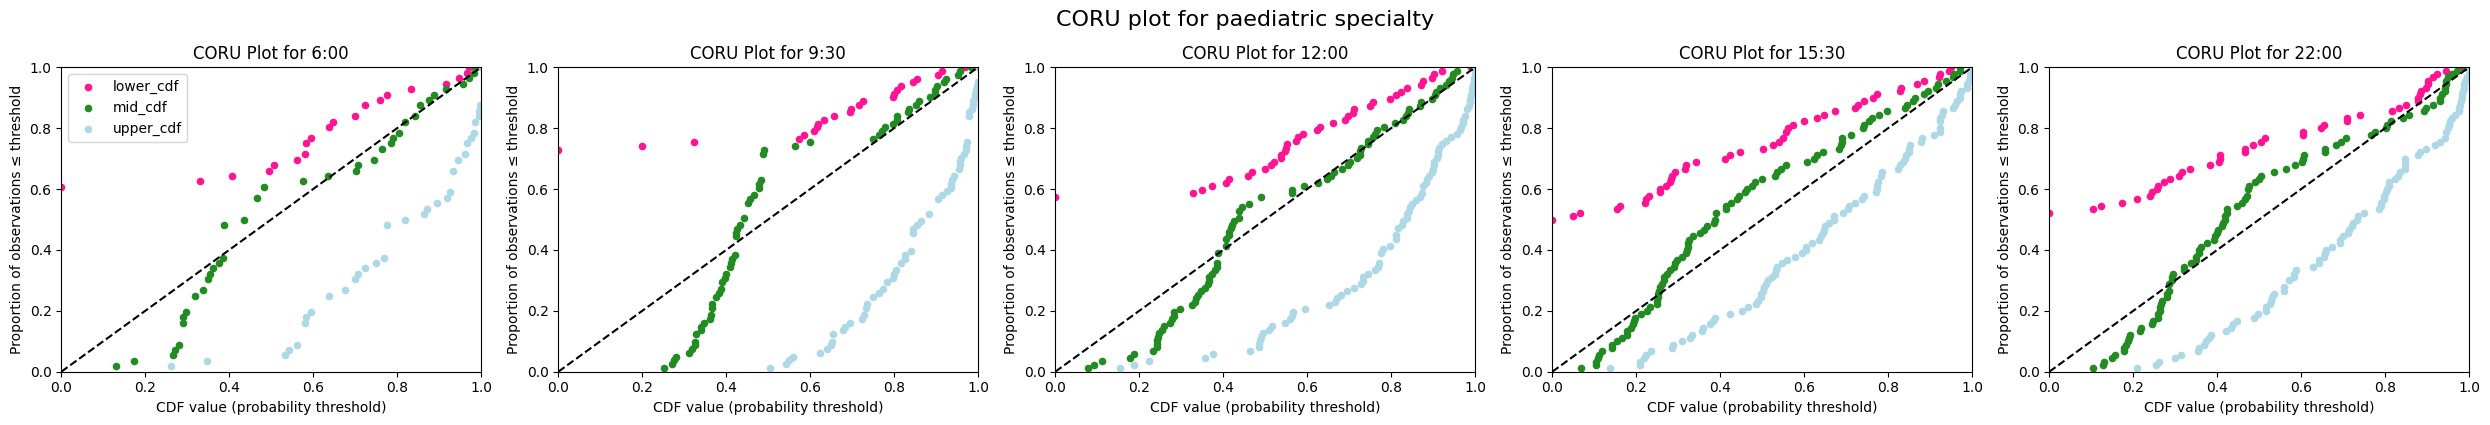

In [28]:
from patientflow.viz.coru_plot import coru_plot

for specialty in ['paediatric']:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    coru_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="admissions",
            suptitle=f"CORU plot for {specialty} specialty", 
            print_n_iterations=5)

2031-10-01: [[0.549513852097664]
 [0.343569924453347]
 [0.0919689785283301]
 [0.0136635697290782]
 [0.00121677574905458]
 [6.49507636451421e-5]
 [1.92426954211985e-6]
 [2.44093391099540e-8]]
2031-10-02: [[0.655439225309916]
 [0.294947662690470]
 [0.0464269487228810]
 [0.00311030224338684]
 [7.58610333455499e-5]]
2031-10-03: [[0.461028719196459]
 [0.386866430939584]
 [0.128430229911129]
 [0.0216200638061596]
 [0.00196124461528459]
 [9.15811664303952e-5]
 [1.73036495325715e-6]]
2031-10-05: [[0.713180930863479]
 [0.261711822226889]
 [0.0244725874041791]
 [0.000634659505452794]
 [0]]
2031-10-11: [[0.490277085075665]
 [0.394505139675494]
 [0.102480427674511]
 [0.0120540665398021]
 [0.000668989703415010]
 [1.42913311122965e-5]]
2031-10-12: [[0.308110628596288]
 [0.401756395391848]
 [0.214500401083730]
 [0.0628608006253664]
 [0.0113391786182331]
 [0.00132535219558626]
 [0.000101984075797613]
 [5.09888469056440e-6]
 [1.57806014517651e-7]
 [2.70333032624299e-9]
 [1.91147210633430e-11]]
2031-10-

,value,cum_weight_normed,dist
0,0,0.522222,lower_cdf
1,0.107908648028628,0.533333,lower_cdf
2,0.131487618500380,0.544444,lower_cdf
3,0.154439895207127,0.555556,lower_cdf
4,0.164716461811561,0.566667,lower_cdf
...,...,...,...
210,0.985465665447896,0.944444,upper_cdf
211,0.987121095885058,0.955556,upper_cdf
212,0.991971158409415,0.966667,upper_cdf
213,0.997369039610317,0.977778,upper_cdf


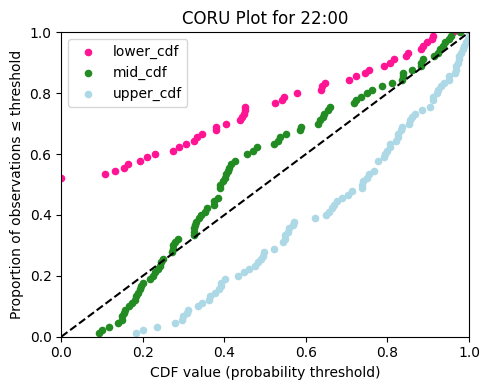

In [34]:
from patientflow.viz.coru_plot import coru_plot

specialty_prob_dist = {time: dist_dict['paediatric'] for time, dist_dict in prob_dist_dict_all.items()}

df = coru_plot([(22,00)], 
        specialty_prob_dist,
        model_name="admissions", 
        return_dataframe=True)

obs_df = df['admissions_2200']

plot_data = []

for cdf_type in ['lower_cdf', 'mid_cdf', 'upper_cdf']:
        # Sort values
        sorted_values = sorted(obs_df[cdf_type])
        
        # Calculate empirical CDF
        n = len(sorted_values)
        cdf_data = []
        
        # Group by unique CDF values and count occurrences
        unique_values = pd.Series(sorted_values).value_counts().sort_index()
        cumulative_prop = 0
        
        for value, count in unique_values.items():
                proportion = count / n
                cumulative_prop += proportion
                cdf_data.append({
                        'value': value,
                        'cum_weight_normed': cumulative_prop,
                        'dist': cdf_type
                })
        
        plot_data.extend(cdf_data)

pd.DataFrame(plot_data)

In [36]:
cdf_type = 'upper_cdf'
sorted_values = sorted(obs_df[cdf_type])
sorted_values

# Calculate empirical CDF
n = len(sorted_values)
cdf_data = []

# Group by unique CDF values and count occurrences
unique_values = pd.Series(sorted_values).value_counts().sort_index()
unique_values



0.184399129748768    1
0.199216175535362    1
0.234083194793372    1
0.279886046867218    1
0.296025289462931    1
                    ..
0.985465665447896    1
0.987121095885058    1
0.991971158409415    1
0.997369039610317    1
1.00000000000000     2
Name: count, Length: 85, dtype: int64

In [31]:
cumulative_prop = 0
cdf_data = []

for value, count in unique_values.items():
        proportion = count / n
        print(f'value: {value}, count: {count}, proportion: {proportion}')
        cumulative_prop += proportion
        cdf_data.append({
                'value': value,
                'cum_weight_normed': cumulative_prop,
                'dist': cdf_type
        })

cdf_data

value: 0.184399129748768, count: 1, proportion: 0.011111111111111112
value: 0.199216175535362, count: 1, proportion: 0.011111111111111112
value: 0.234083194793372, count: 1, proportion: 0.011111111111111112
value: 0.279886046867218, count: 1, proportion: 0.011111111111111112
value: 0.296025289462931, count: 1, proportion: 0.011111111111111112
value: 0.299297993168917, count: 1, proportion: 0.011111111111111112
value: 0.308110628596288, count: 1, proportion: 0.011111111111111112
value: 0.310490857228979, count: 1, proportion: 0.011111111111111112
value: 0.334435684368412, count: 1, proportion: 0.011111111111111112
value: 0.344915076394646, count: 1, proportion: 0.011111111111111112
value: 0.362402510428474, count: 1, proportion: 0.011111111111111112
value: 0.365655292594421, count: 1, proportion: 0.011111111111111112
value: 0.376434422381629, count: 1, proportion: 0.011111111111111112
value: 0.387185679211738, count: 1, proportion: 0.011111111111111112
value: 0.390803836382747, count: 1

[{'value': 0.184399129748768,
  'cum_weight_normed': 0.011111111111111112,
  'dist': 'upper_cdf'},
 {'value': 0.199216175535362,
  'cum_weight_normed': 0.022222222222222223,
  'dist': 'upper_cdf'},
 {'value': 0.234083194793372,
  'cum_weight_normed': 0.03333333333333333,
  'dist': 'upper_cdf'},
 {'value': 0.279886046867218,
  'cum_weight_normed': 0.044444444444444446,
  'dist': 'upper_cdf'},
 {'value': 0.296025289462931,
  'cum_weight_normed': 0.05555555555555556,
  'dist': 'upper_cdf'},
 {'value': 0.299297993168917,
  'cum_weight_normed': 0.06666666666666667,
  'dist': 'upper_cdf'},
 {'value': 0.308110628596288,
  'cum_weight_normed': 0.07777777777777778,
  'dist': 'upper_cdf'},
 {'value': 0.310490857228979,
  'cum_weight_normed': 0.08888888888888889,
  'dist': 'upper_cdf'},
 {'value': 0.334435684368412, 'cum_weight_normed': 0.1, 'dist': 'upper_cdf'},
 {'value': 0.344915076394646,
  'cum_weight_normed': 0.11111111111111112,
  'dist': 'upper_cdf'},
 {'value': 0.362402510428474,
  'cum_

## Generate predicted distributions and observed number of admissions for each specialty and prediction time for patients yet-to-arrive to the ED

As the predictions for yet-to-arrive patients are aspirational, these cannot be directly compared with observed numbers of patients who arrived after the moment of prediction, and were admitted within the prediction window. Due to slower than target processing of patients through the ED, these future arrivals would have a smaller likelihood of being admitted within the window than suggested by the aspirational target. 

We can, however, compare the predictions based on arrival rates at the front door of ED, that were learned from the training set, against observed arrival rates at the front door during the test set. The observed arrivals can be adjusted using the same time-dependent probability of admission during the window. I have used a deterministic weighting where each patient contributes fractionally to the total number of admissions, based on their arrival time. If for example a patient arriving 3 hours into the prediction window has a 0.8 probability of admission, they would contribute 0.8 to the weighted observed count.

The function `get_prob_dist_without_patient_snapshots` saves a predicted distribution for each prediction moment in the test set, and the weighted observed count of patients later admitted who arrived during the prediction window, for later plotting.


In [14]:
from patientflow.aggregate import get_prob_dist_without_patient_snapshots
from datetime import timedelta


# Create date range
snapshot_dates = []
start_date = start_test_set
end_date = end_test_set

current_date = start_date
while current_date < end_date:
    snapshot_dates.append(current_date)
    current_date += timedelta(days=1)

prob_dist_dict_for_yta = {}

# Process each time of day
for _prediction_time in ed_visits.prediction_time.unique():

    print("\nProcessing :" + str(_prediction_time))
    model_key = get_model_key('yta', _prediction_time)

    prob_dist_dict_for_yta[model_key] =  get_prob_dist_without_patient_snapshots(
        prediction_time=_prediction_time, 
        categories=specialties, 
        model=yta_model_by_spec, 
        test_df=test_inpatient_arrivals_df, 
        prediction_window=prediction_window, 
        x1=x1, y1=y1, x2=x2, y2=y2, 
        snapshot_dates=snapshot_dates,
        datetime_col='arrival_datetime')


Processing :(12, 0)

Processing :(15, 30)

Processing :(6, 0)

Processing :(9, 30)

Processing :(22, 0)


In [15]:
# ## Alternative method, not weighted, just using Poisson distribution

# def count_yet_to_arrive(df, snapshot_dates, prediction_times, prediction_window_hours):
#     """
#     Count patients who arrived after a prediction time and were admitted to a ward 
#     within a specified window.
#     """
#     # Create an empty list to store results
#     results = []
    
#     # For each combination of date and time
#     for date_val in snapshot_dates:
#         for hour, minute in prediction_times:
#             # Create the prediction datetime
#             prediction_datetime = pd.Timestamp(datetime.combine(date_val, time(hour=hour, minute=minute)), tz='UTC')

#             # Calculate the end of the prediction window
#             prediction_window_end = prediction_datetime + pd.Timedelta(hours=prediction_window_hours)
            
#             # Count patients who arrived after prediction time and were admitted within the window
#             arrived_within_window = len(df[
#                 (df['arrival_datetime'] > prediction_datetime) & 
#                 (df['arrival_datetime'] <= prediction_window_end)
#             ])
            
#             # Store the result
#             results.append({
#                 'snapshot_date': date_val,
#                 'prediction_time': (hour, minute),
#                 'count': arrived_within_window
#             })
    
#     # Convert results to a DataFrame
#     results_df = pd.DataFrame(results)
    
#     return results_df
# yet_to_arrive_counts = count_yet_to_arrive(
#     train_inpatient_arrivals_df, snapshot_dates, ed_visits.prediction_time.unique(), prediction_window_hours=8)

# from scipy import stats
# poisson_mean = yet_to_arrive_counts['count'].mean()
# poisson_model = stats.poisson(poisson_mean)
                              
# prob_dist_dict_for_yta = {}

# # Process each time of day
# for _prediction_time in ed_visits.prediction_time.unique():

#     print("\nProcessing :" + str(_prediction_time))
#     model_key = get_model_key('yta', _prediction_time)

#     prob_dist_dict_for_yta[model_key] =  get_prob_dist_without_patient_snapshots(
#         prediction_time=_prediction_time, 
#         categories=specialties, 
#         model=poisson_model, 
#         test_df=test_inpatient_arrivals_df, 
#         prediction_window=prediction_window, 
#         snapshot_dates=snapshot_dates,
#         datetime_col='arrival_datetime',
#         max_range=50)

## Visualise the performance of emergency demand prediction models for patients yet-to-arrive to the ED

Using the same visualisation methods as above, for ease of comparison, we can evaluate whether the arrival rates at the front door were in line with those predicted. 

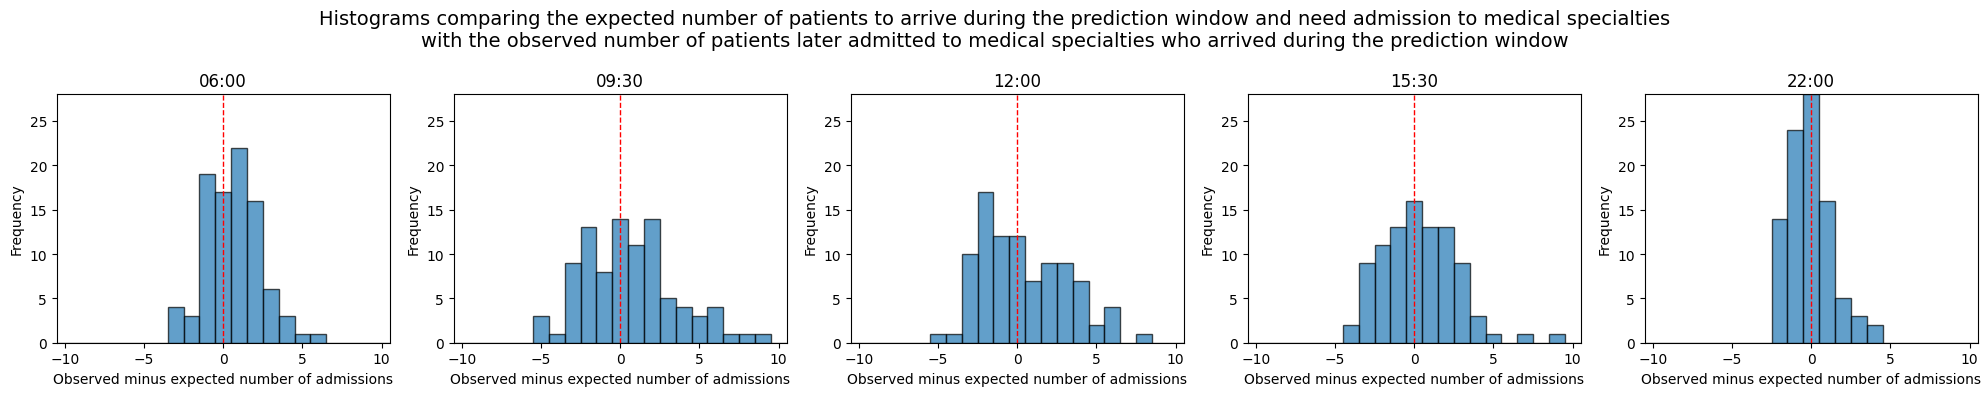

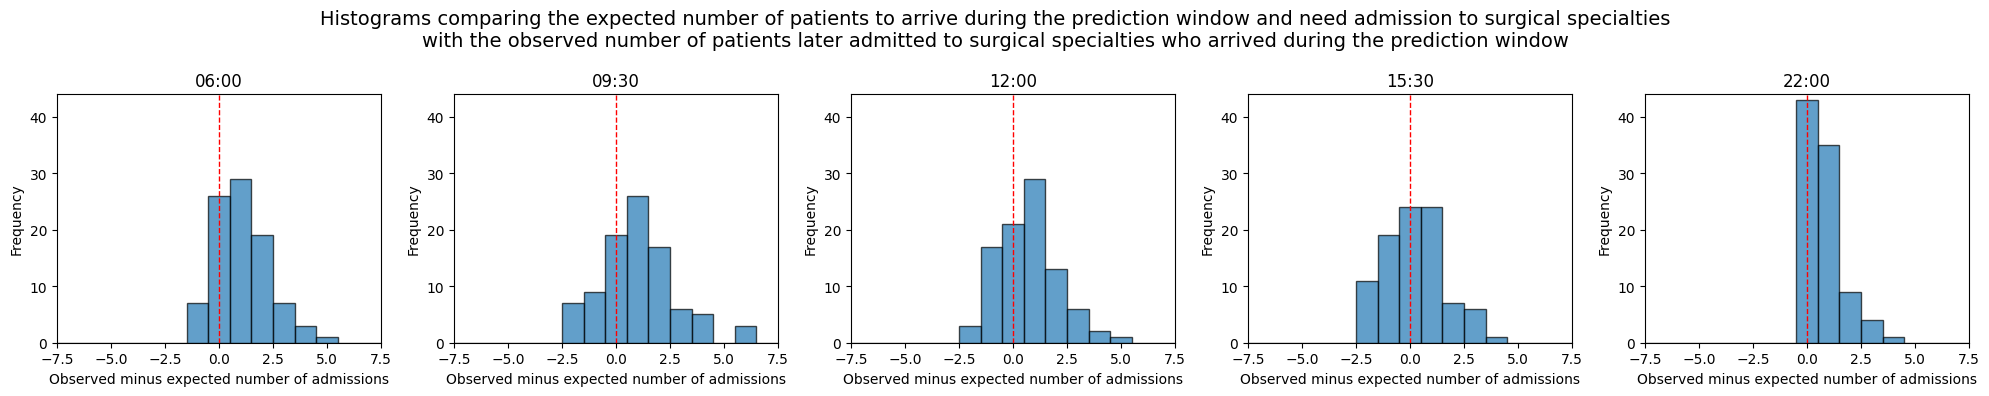

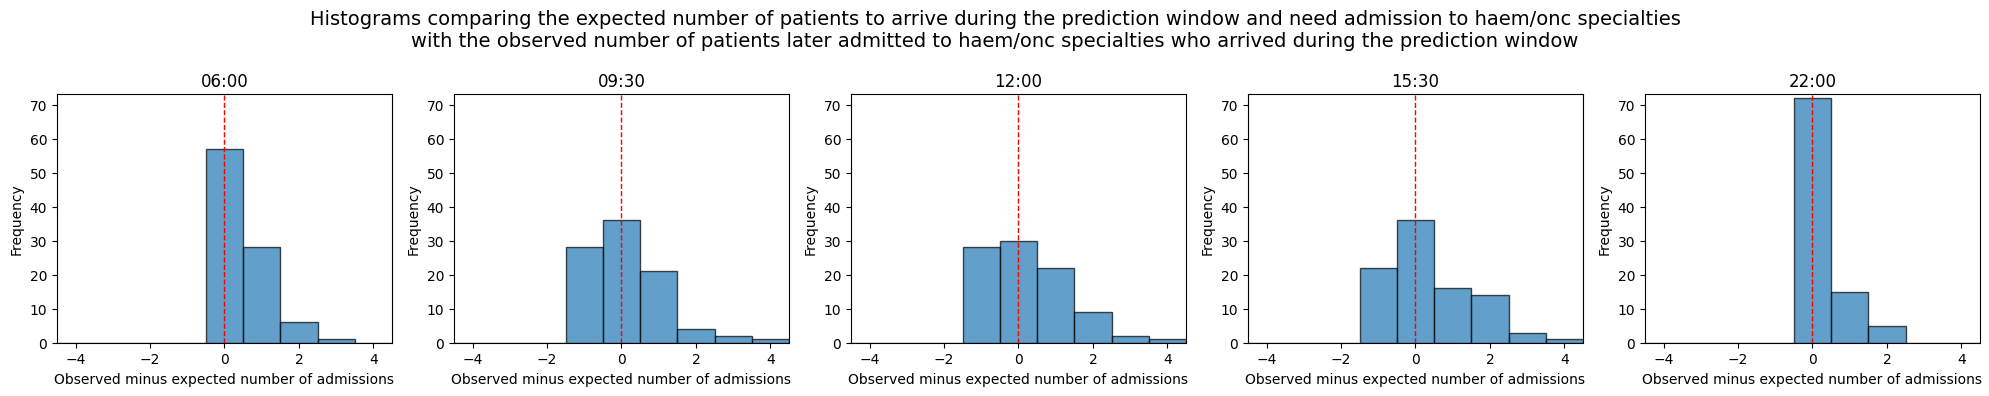

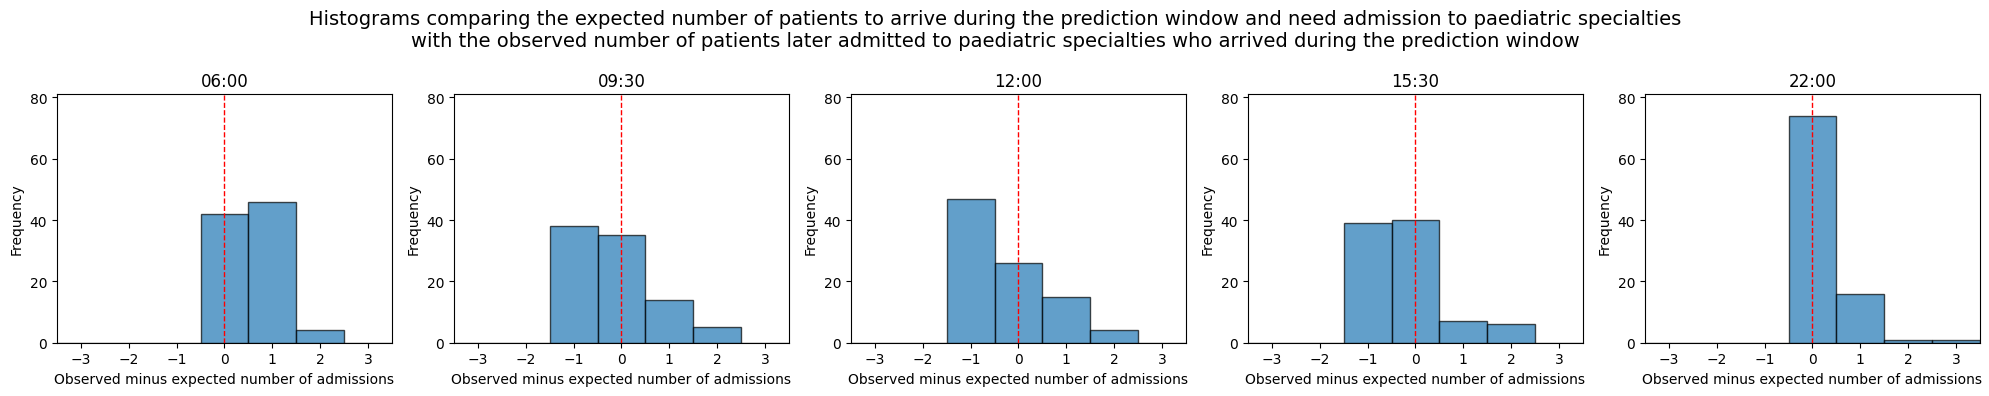

In [275]:
from patientflow.evaluate import calc_mae_mpe
from patientflow.viz.evaluation_plots import plot_observed_against_expected

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_for_yta.items()}
    results = calc_mae_mpe(specialty_prob_dist)
    plot_observed_against_expected(results, 
                                   main_title=f"Histograms comparing the expected number of patients to arrive during the prediction window and need admission to {specialty} specialties" + 
                                   f"\nwith the observed number of patients later admitted to {specialty} specialties who arrived during the prediction window")

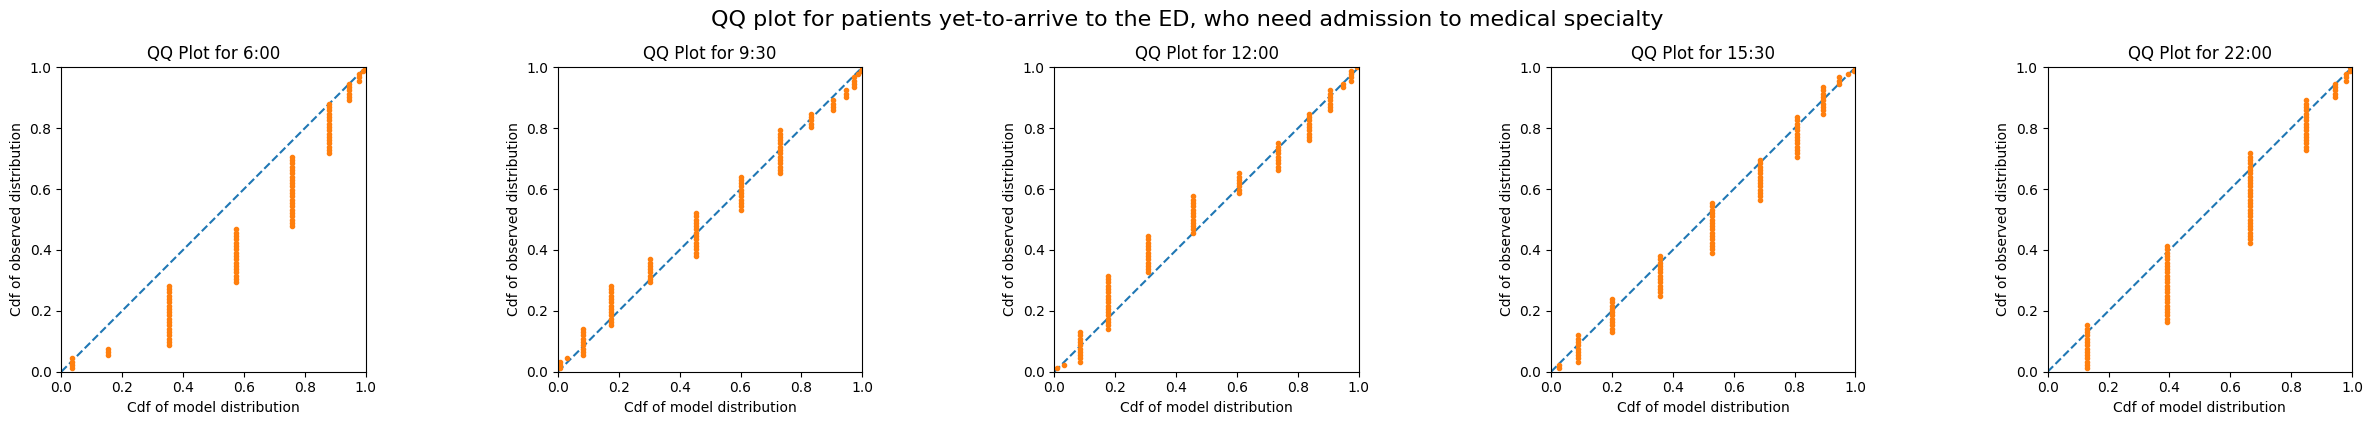

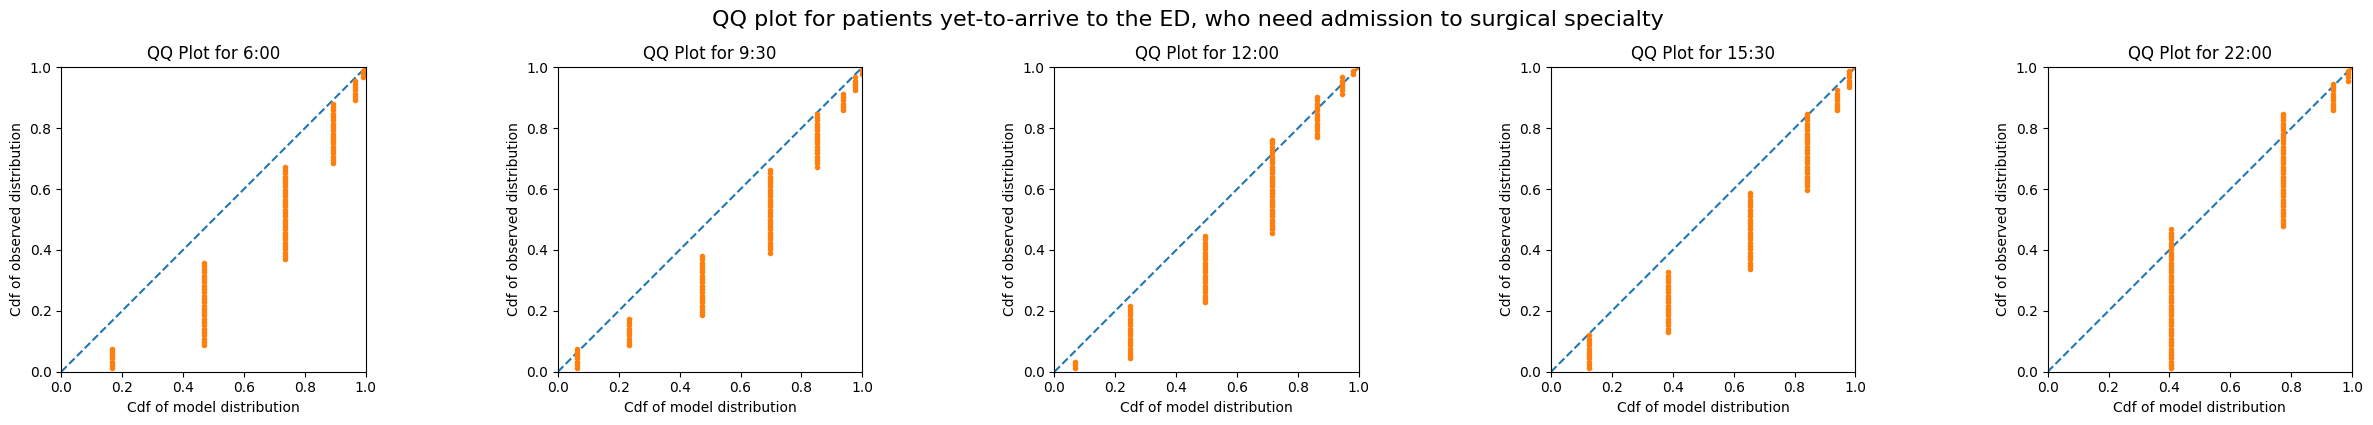

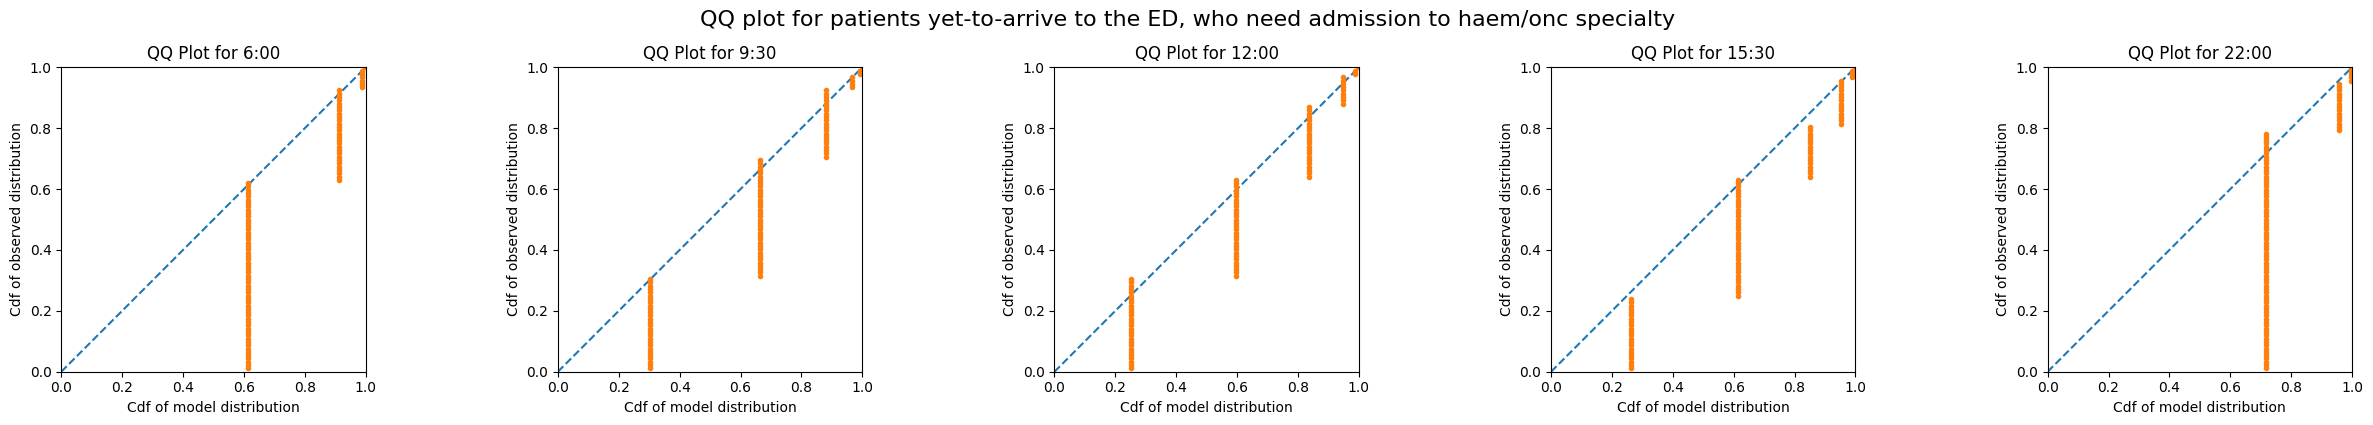

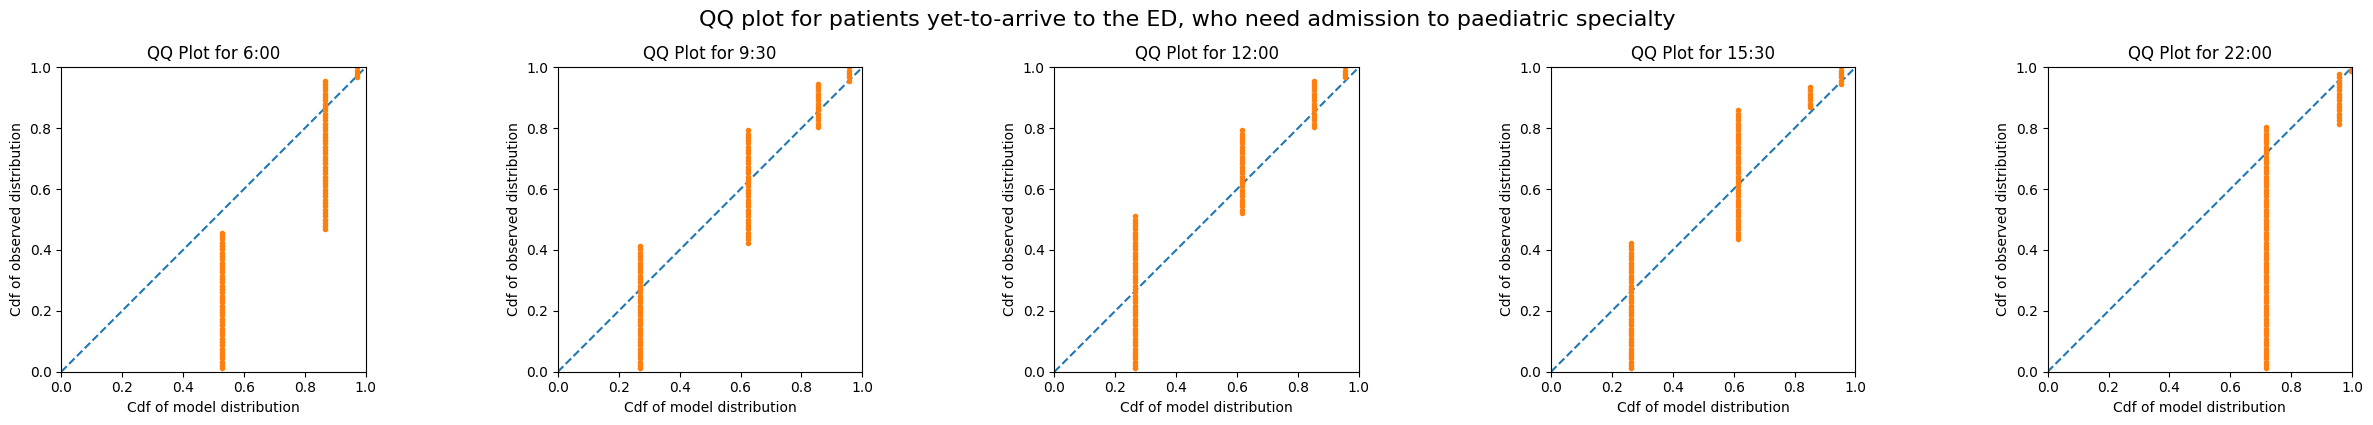

In [276]:
from patientflow.viz.qq_plot import qq_plot

for specialty in specialties:

    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_for_yta.items()}

    qq_plot(ed_visits.prediction_time.unique(), 
            specialty_prob_dist,
            model_name="yta",
            suptitle=f"QQ plot for patients yet-to-arrive to the ED, who need admission to {specialty} specialty")

The histograms are roughly centred around zero. 

The vertical segements in the QQ plots show "staircase" pattern rather than a smooth line. There are two reasons: 

* The weighted observed counts are discrete (rounded to the nearest integer), which creates discrete jumps in the empirical distribution rather than a smooth progression. 
* The Poisson arrival rates in the model vary only by time of day, resulting in identical predicted distributions for each day in the test set. Since the x-axis represents the CDF of the model distribution, these identical predictions create consistent, fixed points along the axis where probability mass concentrates, resulting in large gaps between these points.

The predictions for medical specialties are well-calibrated with histograms centered near zero. The QQ plots demonstrate good alignment with the theoretical distribution. Similarly, the surgical predictions show good calibration and consistent diagonal alignment with moderate step patterns. The other two have concentrated prediction errors with narrower histograms, reflecting the smaller patient volumes and more pronounced vertical segments but maintain acceptable alignment.

## Conclusion

In this notebook I have shown how to evaluate predicted bed counts for the patients in ED, by specialty, and for the patients yet-to-arrive. Both approaches required adjustments for the fact that the predicted distributions are aspirational. 

These models are based on a relatively small dataset (six months of training data, a one month validation set and a 3 month test set).  In the real-time application at UCLH, we use much more training data, and we also have the benefit of some additional features (such as age as a continuous variable) which improves model performance. 

Nonetheless, the models perform well on the relatively small datasets made available here. 